# Sentiment Analysis with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

In [1]:
# Install required libraries
%pip install torch
%pip install transformers
%pip install datasets

  Using cached torch-2.0.1-cp39-cp39-win_amd64.whl (172.4 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `3 epochs of fine-tuning`. 

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

In [2]:
import os
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

In [3]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [4]:
# Load the train dataset
train_df = pd.read_csv('data/Train.csv')
train_df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [5]:
# Load the test dataset
test_df = pd.read_csv('data/Test.csv')
test_df.head()

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


# Exploratory Data Analysis: EDA

### Column Information of The Datasets

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


- The train DataFrame contains a total of 10,001 entries (rows), and four columns: 'tweet_id', 'safe_text', 'label', and 'agreement'.
- The 'tweet_id' and 'safe_text' columns are of type 'object', typically representing strings. The 'label' and 'agreement' columns are of type 'float64', indicating floating-point numbers.
- The 'label' and 'agreement' columns contain missing values.

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5177 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


- The test DataFrame consists of 5,177 entries (rows), and two columns: 'tweet_id' and 'safe_text'.
- Both columns, 'tweet_id' and 'safe_text', are of type 'object', representing strings.
- The 'safe_text' column has a missing value.

In [8]:
# Checking the shape of the train dataset
train_df.shape

(10001, 4)

The train dataset as earlier mentioned has 1001 rows and 4 columns.

In [9]:
# Checking the shape of the train dataset
test_df.shape

(5177, 2)

The test dataset has 5177 rows and 2 columns. The dataset lacks the 'label' and the 'safe_test' columns. 

### Checking for and Handling Missing Values

#### Train Data

In [10]:
# Checking for missing values in the train dataset
train_df.isnull().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [11]:
# Drop The Rows With Missing Data
train_df = train_df.dropna()

# Confirm if the missing values have been handled
train_df.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

#### Test Data

In [12]:
# Checking for missing values in the test dataset
test_df.isnull().sum()

tweet_id     0
safe_text    1
dtype: int64

In [13]:
# Drop The Rows With Missing Data
test_df = test_df.dropna()

# Confirm if missing values have been handled
test_df.isnull().sum()

tweet_id     0
safe_text    0
dtype: int64

All missing Values in the Train and Test Datasets have been handled.

### Visualizing The Distribution of Data In The Different Datasets

#### i. Distribution of The 'label' column

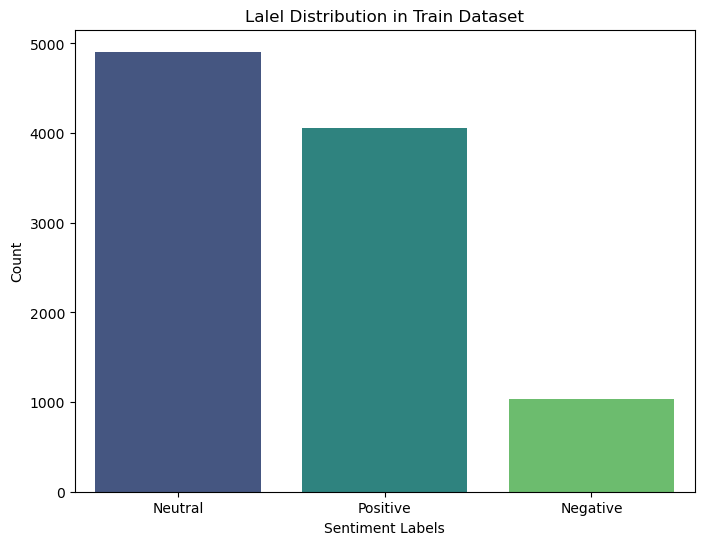

In [14]:
# Replace numeric sentiment labels with descriptive words
label_mapping = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
train_df['label'] = train_df['label'].map(label_mapping)

# Class Distribution in 'label' column with 'viridis' color palette
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='label', palette='viridis')
plt.title('Lalel Distribution in Train Dataset')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.show()

The plot visualizes the distribution of sentiment labels ('Negative,' 'Neutral,' 'Positive') in the training dataset.
From the plot, we can observe the following insights:
- The 'Neutral' sentiment appears to be the most frequent category, followed by 'Positive,' and 'Negative' sentiments.
- The sentiment classes seem to be relatively balanced, with 'Neutral' having the highest count and 'Negative' having the lowest count.
- This balance suggests that the dataset does not suffer from severe class imbalance issues, which is beneficial for model training.

### ii. Exploration of Text Data (Tweet_Length)

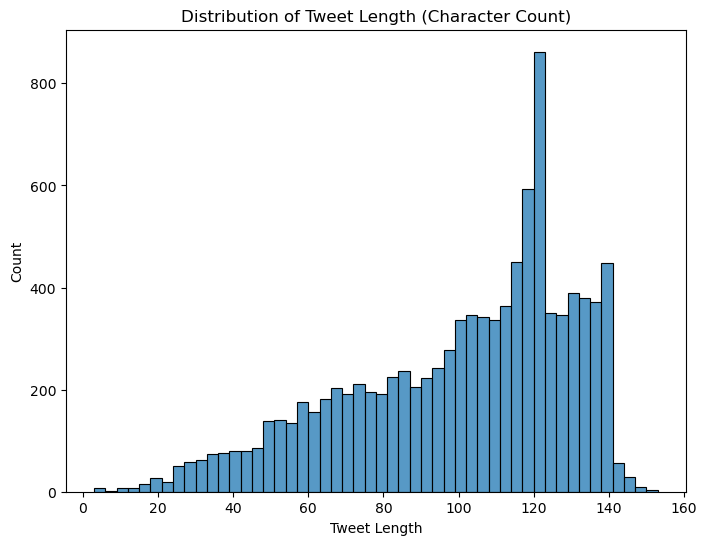

In [15]:
# Calculate and visualize the length of tweets
train_df['tweet_length'] = train_df['safe_text'].apply(len)

plt.figure(figsize=(8, 6))
sns.histplot(train_df['tweet_length'], bins=50, palette='viridis')
plt.title("Distribution of Tweet Length (Character Count)")
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.show()

The plot explores the distribution of tweet lengths in terms of character count. Insights from this plot include:
- The distribution is left-skewed, with most tweets having relatively longer character counts.
- There is a peak in the distribution around the 100-150 character mark.
- This suggests that a substantial portion of tweets related to vaccination topics is relatively concise, but there is also a presence of shorter tweets.
- These insights can be valuable for further data preprocessing and model development. Understanding the distribution of tweet lengths can help in deciding the appropriate text preprocessing techniques and model architectures for handling different text lengths effectively.For instance, models should be capable of handling both longer and shorter texts effectively, considering the variability in tweet lengths within the dataset.

### iii. Exploration of Text Data

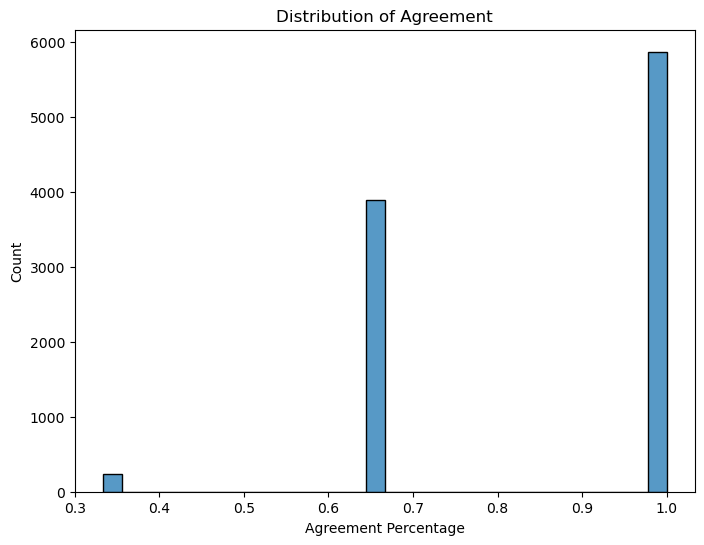

In [16]:
# Plot the distribution of agreement
plt.figure(figsize=(8, 6))
sns.histplot(train_df['agreement'], bins=30)
plt.title("Distribution of Agreement")
plt.xlabel("Agreement Percentage")
plt.ylabel("Count")
plt.show()

The plot visualizes the distribution of the agreement percentages in the training dataset. The agreement percentage indicates the percentage of reviewers who agreed on the sentiment label for a given tweet.
Key insights from this plot:
- Many tweets in the dataset have a consensus among reviewers regarding their sentiment labels.
- However, there is also a presence of tweets with lower agreement percentages, indicating potential disagreement among reviewers on sentiment labeling.

### Visualize Word Cloud From  The Text Contained in The Tweets

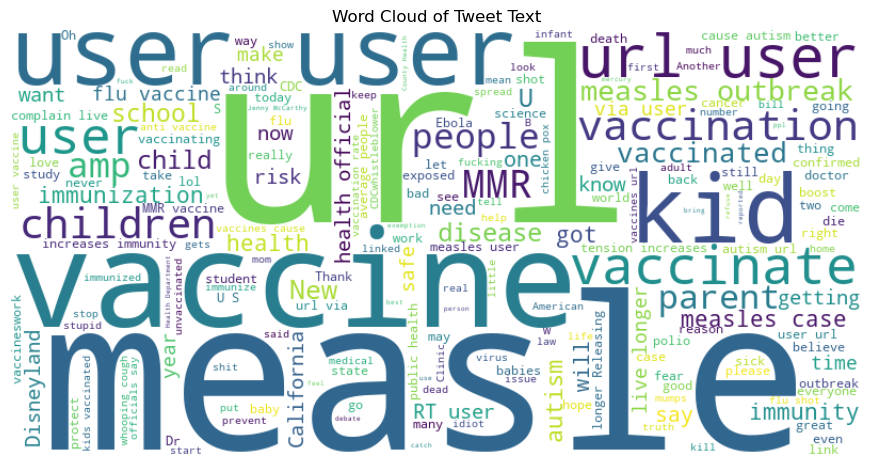

In [17]:
# Generate a word cloud from the tweet text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train_df['safe_text']))

plt.figure(figsize=(11, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Tweet Text")
plt.axis('off')
plt.show()

The plot presents a word cloud generated from the tweet text in the training dataset.
Insights from this word cloud:
- The most frequent words in the tweet text are displayed in larger fonts, making them easily identifiable.
- Common words related to vaccination topics, and public health such as vaccine, vaccinate, vaccination are more prominent in the word cloud.
- This visualization provides a qualitative view of the textual content in the dataset, highlighting the importance of certain words or phrases.

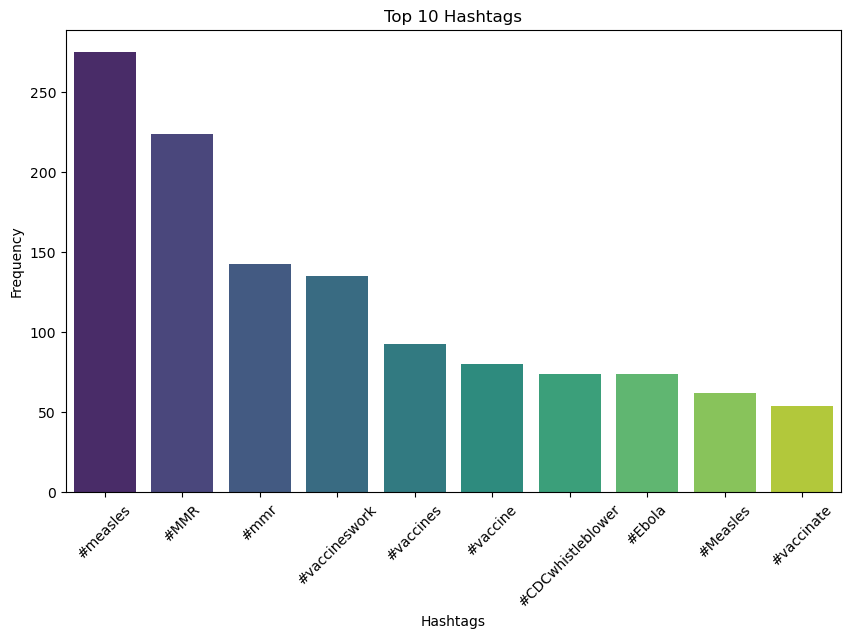

In [18]:
# Extract hashtags from the 'safe_text' column
hashtags = train_df['safe_text'].str.findall(r'#\w+')

# Flatten the list of lists into a single list of hashtags
hashtags = [item for sublist in hashtags for item in sublist]

# Count the frequency of each hashtag
hashtag_freq = Counter(hashtags)

# Get the top 10 hashtags
top_10_hashtags = dict(hashtag_freq.most_common(10))

# Create a bar plot to visualize the top 10 hashtags with the 'viridis' color palette
plt.figure(figsize=(10, 6))
sns.barplot(x=list(top_10_hashtags.keys()), y=list(top_10_hashtags.values()), palette='viridis')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.title('Top 10 Hashtags')
plt.xticks(rotation=45)
plt.show()

The bar plot reveals the top 10 hashtags that are most frequently used in the Twitter posts within the dataset
Each hashtag represents a topic or theme discussed in the Twitter posts. By examining the top hashtags, we identify the most prevalent topics of discussion among Twitter users. 

# Splitting the Train Dataset Into Train and Evaluation Subsets

I manually split the training set to have a training subset ( a dataset the model will learn on), and an evaluation subset ( a dataset the model with use to compute metric scores to help use to avoid some training problems like [the overfitting](https://www.ibm.com/cloud/learn/overfitting) one ). 

There are multiple ways to do split the dataset. You'll see two commented line showing you another one.

In [19]:
# Split the train data => {train, eval}
train, eval = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

In [20]:
train.head()

,tweet_id,safe_text,label,agreement,tweet_length
9305,YMRMEDME,Mickey's Measles has gone international <url>,Neutral,1.000000,45
3907,5GV8NEZS,S1256 [NEW] Extends exemption from charitable ...,Neutral,1.000000,122
795,EI10PS46,<user> your ignorance on vaccines isn't just ...,Positive,0.666667,118
5793,OM26E6DG,Pakistan partly suspends polio vaccination pro...,Neutral,1.000000,93
3431,NBBY86FX,In other news I've gone up like 1000 mmr,Neutral,1.000000,40


In [21]:
eval.head()

,tweet_id,safe_text,label,agreement,tweet_length
6571,R7JPIFN7,Children's Museum of Houston to Offer Free Vac...,Positive,1.000000,61
1754,2DD250VN,<user> no. I was properly immunized prior to t...,Positive,1.000000,102
3325,ESEVBTFN,<user> thx for posting vaccinations are impera...,Positive,1.000000,120
1485,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,Positive,0.666667,69
4175,IIN5D33V,"Meeting tonight, 8:30pm in room 322 of the stu...",Positive,1.000000,118


In [22]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (7999, 5), eval is (2000, 5)


In [23]:
# Save splitted subsets
train.to_csv("data/train_subset.csv", index=False)
eval.to_csv("data/eval_subset.csv", index=False)

In [24]:
dataset = load_dataset('csv',
                        data_files={'train': 'data/train_subset.csv',
                        'eval': 'data/eval_subset.csv'}, encoding = "ISO-8859-1")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [25]:
# Import the Tokenizer 
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [26]:
# Function for transforming the labels 
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [27]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tweet_length', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['tweet_length', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [28]:
# dataset['train']

In [29]:
from transformers import TrainingArguments

# Configure the trianing parameters like `num_train_epochs`: 
# the number of time the model will repeat the training loop over the dataset
training_args = TrainingArguments("test_trainer", num_train_epochs=3000, load_best_model_at_end=True,)

ValueError: --load_best_model_at_end requires the save and eval strategy to match, but found
- Evaluation strategy: no
- Save strategy: steps

In [ ]:
from transformers import AutoModelForSequenceClassification

# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

In [ ]:
train_dataset = dataset['train'].shuffle(seed=10) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10)

## other way to split the train set ... in the range you must use: 
# # int(num_rows*.8 ) for [0 - 80%] and  int(num_rows*.8 ),num_rows for the 20% ([80 - 100%])
# train_dataset = dataset['train'].shuffle(seed=10).select(range(40000))
# eval_dataset = dataset['train'].shuffle(seed=10).select(range(40000, 41000))

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset
)

In [ ]:
# Launch the learning process: training 
trainer.train()

Don't worry the above issue, it is a `KeyboardInterrupt` that means I stopped the training to avoid taking a long time to finish.

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Launch the final evaluation 
trainer.evaluate()

Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

Do not hesitaite to read more and to ask questions, the Learning is a lifelong activity.